<a href="https://colab.research.google.com/github/khashayard/HumanMotion/blob/main/HumanMotionNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense , Dropout,Input , BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.regularizers import l2 , l1_l2

# 📥 دانلود دیتاست با kagglehub



In [82]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("meetnagadia/human-action-recognition-har-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/human-action-recognition-har-dataset


In [83]:
ls /kaggle/input/human-action-recognition-har-dataset/

'Human Action Recognition'/


# 📂 مسیرهای دیتاست



In [84]:
train_path = "/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/train"
test_path = "/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/test"
train_csv_path = "/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/Training_set.csv"
test_csv_path = "/kaggle/input/human-action-recognition-har-dataset/Human Action Recognition/Testing_set.csv"

# 📊 بارگذاری داده‌ها و دسته‌بندی‌ها


In [89]:
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)
categories = train_df['label'].astype('category').cat.categories

# 🖼️ نمایش نمونه تصاویر از هر کلاس


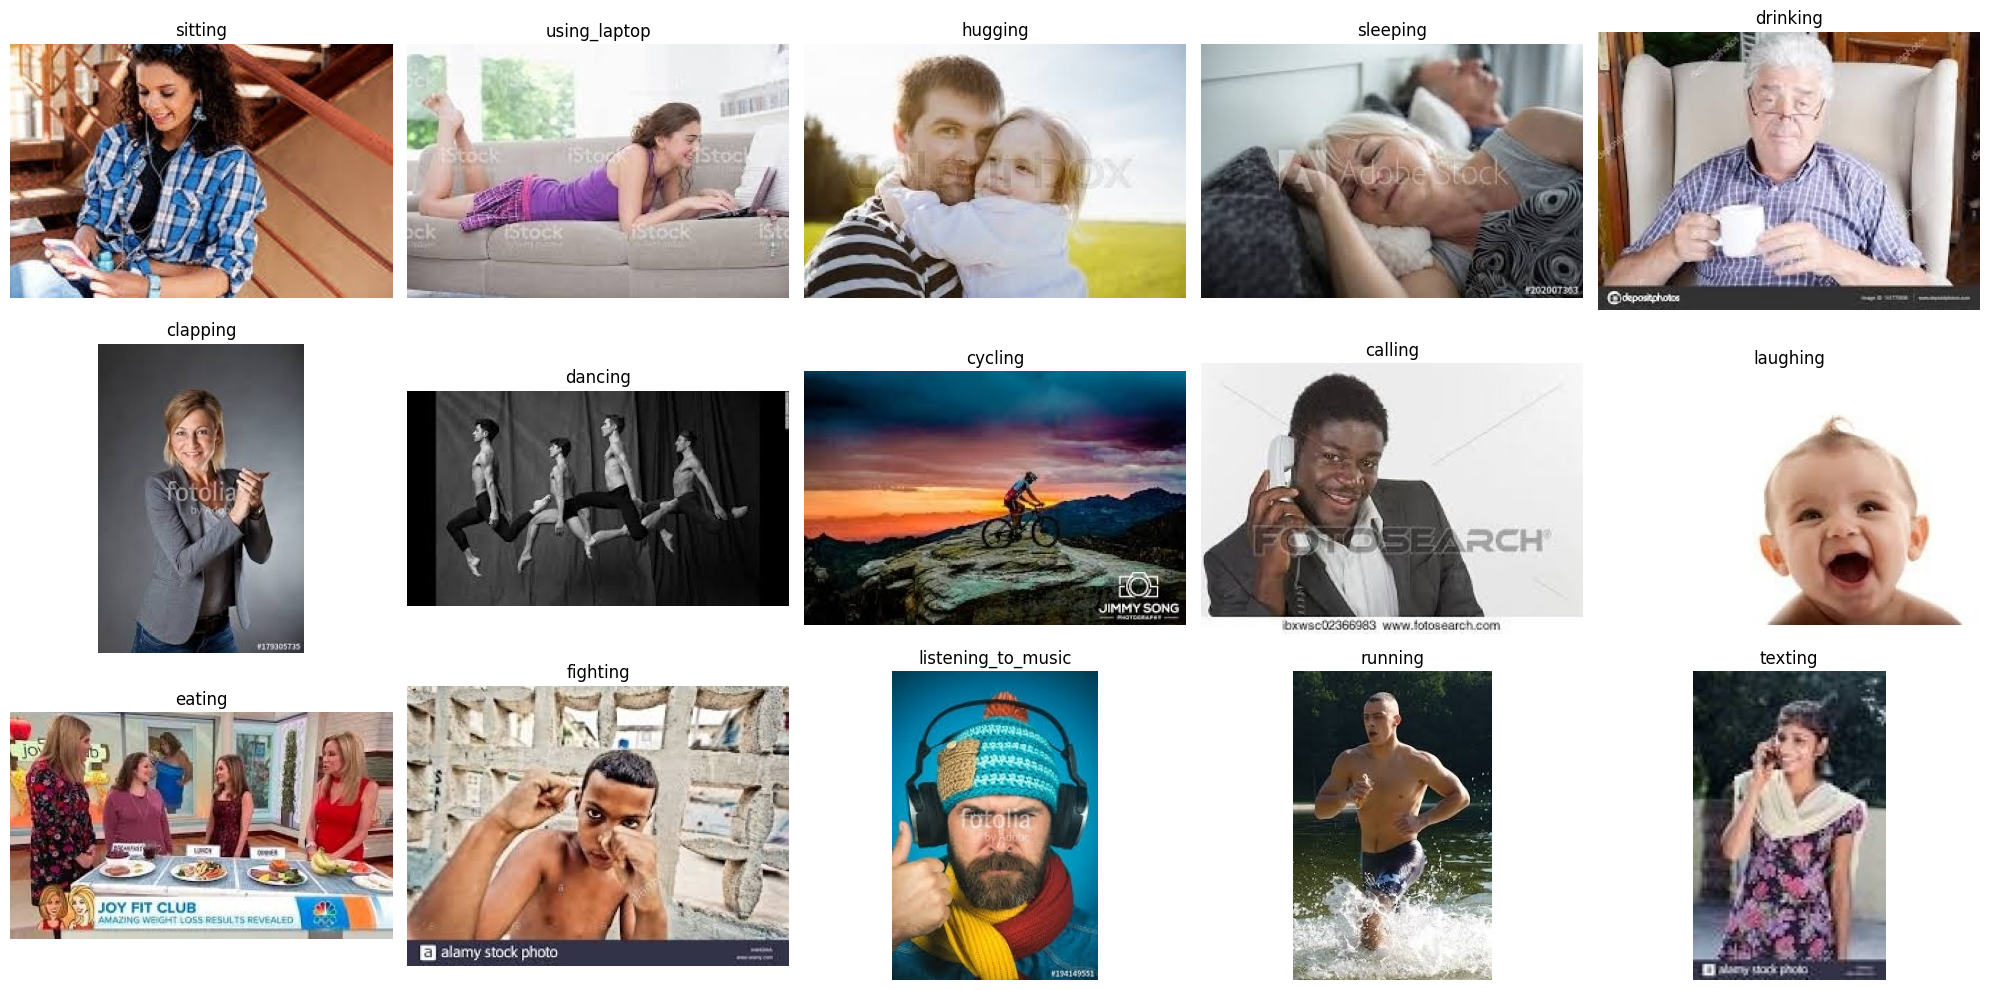

In [10]:
fig, axes = plt.subplots(3, 5, figsize=(20, 10))
axes = axes.flatten()
for idx, class_name in enumerate(train_df['label'].unique()):
    class_images = train_df[train_df['label'] == class_name]['filename'].values
    img = plt.imread(os.path.join(train_path, class_images[0]))
    axes[idx].imshow(img)
    axes[idx].set_title(class_name)
    axes[idx].axis('off')
plt.tight_layout()
plt.show()

# 🧹 آماده‌سازی داده‌ها برای آموزش مدل


In [90]:
train_df['label'] = train_df['label'].astype('category')
train_df['label'] = train_df['label'].cat.codes
train_df['filepath'] = train_df['filename'].apply(lambda x: os.path.join(train_path, x))
train_set, val_set = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)

# 🖼️ آماده‌سازی داده‌های تصویری برای مدل Keras با استفاده از `tf.data.Dataset`

### 📥 تابع بارگذاری و پردازش تصویر


In [13]:
def load_image(filepath, label):
    image = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])
    image = image / 255.0
    return image, label

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_set['filepath'].values, train_set['label'].values))
train_dataset = train_dataset.map(load_image).batch(32).shuffle(buffer_size=len(train_set))

val_dataset = tf.data.Dataset.from_tensor_slices((val_set['filepath'].values, val_set['label'].values))
val_dataset = val_dataset.map(load_image).batch(32)

# 🧠 استفاده از Transfer Learning با MobileNetV2 در Keras

### 📦 بارگذاری مدل پایه (Base Model)


In [52]:
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
base_model.trainable = False

# from tensorflow.keras.applications import EfficientNetB3



# base_model = EfficientNetB3(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
# base_model.trainable = False  # یا True برای Fine-Tuning


# 🏗️ ساخت مدل نهایی با استفاده از MobileNetV2 و لایه‌های سفارشی

### 📐 معماری مدل
در این مرحله، با استفاده از مدل پایه‌ی MobileNetV2 و اضافه کردن چند لایه سفارشی، مدل نهایی خود را می‌سازیم:


In [53]:

model = Sequential([
    base_model,
    # Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
    # MaxPooling2D((3, 3)),
    # BatchNormalization(),
    # Dropout(0.2),

    GlobalAveragePooling2D(),
    Dense(60, activation='relu'),
    Dropout(0.5),
    Dense(15, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_14     │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 60)             │        76,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 15)             │           915 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,335,759 (8.91 MB)

 Trainable params: 77,775 (303.81 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## ✅ استفاده از Callbacks برای بهینه‌سازی آموزش مدل



In [54]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_loss',  # معیار برای مانیتور کردن
    patience=5,          # صبر می‌کنه 5 اپوک بدون بهبود بمونه
    restore_best_weights=True  # بعد آموزش بهترین وزن‌ها رو برمی‌گردونه
)

model_checkpoint = ModelCheckpoint(
    'best_model.h5',     # مسیر ذخیره بهترین مدل
    monitor='val_loss',
    save_best_only=True  # فقط وقتی بهبود داشت ذخیره کن
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,          # نرخ یادگیری رو نصف کن
    patience=3,          # اگر 3 اپوک بهبود نبود اعمال کن
    verbose=1
)

# حالا همه رو در یک لیست می‌ریزیم و به fit می‌دیم
callbacks_list = [early_stopping, model_checkpoint, reduce_lr]

## 🧠 آموزش نهایی مدل با استفاده از

In [55]:
history = model.fit(train_dataset, validation_data=val_dataset, batch_size=410,epochs=30,callbacks=callbacks_list)


Epoch 1/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.2363 - loss: 2.4118

315/315 ━━━━━━━━━━━━━━━━━━━━ 172s 499ms/step - accuracy: 0.2366 - loss: 2.4109 - val_accuracy: 0.5357 - val_loss: 1.5182 - learning_rate: 0.0010
Epoch 2/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.4386 - loss: 1.7469

315/315 ━━━━━━━━━━━━━━━━━━━━ 156s 467ms/step - accuracy: 0.4387 - loss: 1.7468 - val_accuracy: 0.5667 - val_loss: 1.3911 - learning_rate: 0.0010
Epoch 3/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.5004 - loss: 1.5323

315/315 ━━━━━━━━━━━━━━━━━━━━ 167s 502ms/step - accuracy: 0.5004 - loss: 1.5323 - val_accuracy: 0.5901 - val_loss: 1.3249 - learning_rate: 0.0010
Epoch 4/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.5302 - loss: 1.4396

315/315 ━━━━━━━━━━━━━━━━━━━━ 169s 513ms/step - accuracy: 0.5302 - loss: 1.4397 - val_accuracy: 0.5944 - val_loss: 1.2989 - learning_rate: 0.0010
Epoch 5/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.5470 - loss: 1.3770

315/315 ━━━━━━━━━━━━━━━━━━━━ 201s 505ms/step - accuracy: 0.5470 - loss: 1.3770 - val_accuracy: 0.5917 - val_loss: 1.2869 - learning_rate: 0.0010
Epoch 6/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.5760 - loss: 1.2974

315/315 ━━━━━━━━━━━━━━━━━━━━ 201s 503ms/step - accuracy: 0.5759 - loss: 1.2976 - val_accuracy: 0.6107 - val_loss: 1.2672 - learning_rate: 0.0010
Epoch 7/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.5883 - loss: 1.2472

315/315 ━━━━━━━━━━━━━━━━━━━━ 165s 493ms/step - accuracy: 0.5883 - loss: 1.2473 - val_accuracy: 0.6012 - val_loss: 1.2655 - learning_rate: 0.0010
Epoch 8/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.5966 - loss: 1.2211

315/315 ━━━━━━━━━━━━━━━━━━━━ 203s 500ms/step - accuracy: 0.5966 - loss: 1.2211 - val_accuracy: 0.6095 - val_loss: 1.2556 - learning_rate: 0.0010
Epoch 9/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.6061 - loss: 1.1758

315/315 ━━━━━━━━━━━━━━━━━━━━ 165s 495ms/step - accuracy: 0.6061 - loss: 1.1759 - val_accuracy: 0.6159 - val_loss: 1.2471 - learning_rate: 0.0010
Epoch 10/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 154s 460ms/step - accuracy: 0.6125 - loss: 1.1584 - val_accuracy: 0.6075 - val_loss: 1.2654 - learning_rate: 0.0010
Epoch 11/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.6186 - loss: 1.1166

315/315 ━━━━━━━━━━━━━━━━━━━━ 165s 500ms/step - accuracy: 0.6186 - loss: 1.1167 - val_accuracy: 0.6214 - val_loss: 1.2379 - learning_rate: 0.0010
Epoch 12/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 164s 494ms/step - accuracy: 0.6258 - loss: 1.0928 - val_accuracy: 0.6127 - val_loss: 1.2755 - learning_rate: 0.0010
Epoch 13/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 164s 493ms/step - accuracy: 0.6281 - loss: 1.0877 - val_accuracy: 0.6091 - val_loss: 1.2697 - learning_rate: 0.0010
Epoch 14/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.6342 - loss: 1.0556
Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
315/315 ━━━━━━━━━━━━━━━━━━━━ 202s 496ms/step - accuracy: 0.6342 - loss: 1.0556 - val_accuracy: 0.6139 - val_loss: 1.2783 - learning_rate: 0.0010
Epoch 15/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 166s 498ms/step - accuracy: 0.6502 - loss: 0.9884 - val_accuracy: 0.6179 - val_loss: 1.2728 - learning_rate: 5.0000e-04
Epoch 16/30
315/315 ━━━━━━━━━━━━━━━━━━━━ 202s 497ms/step - accuracy: 

# 💾 ذخیره و دانلود مدل آموزش‌دیده

در این بخش، مدل نهایی که آموزش داده شده است را ذخیره کرده و آن را دانلود می‌کنیم.


In [56]:
model.save("my_model2.h5")
from google.colab import files
files.download('my_model2.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 📊 نمایش نمودار دقت (Accuracy) و خطا (Loss) مدل




In [59]:

fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(len(history.history['accuracy'])), y=history.history['accuracy'], mode='lines', name='Training Accuracy'))
fig.add_trace(go.Scatter(x=np.arange(len(history.history['val_accuracy'])), y=history.history['val_accuracy'], mode='lines', name='Validation Accuracy'))
fig.update_layout(title='Model Accuracy', xaxis_title='Epoch', yaxis_title='Accuracy')
fig.show()

fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(len(history.history['loss'])), y=history.history['loss'], mode='lines', name='Training Loss'))
fig.add_trace(go.Scatter(x=np.arange(len(history.history['val_loss'])), y=history.history['val_loss'], mode='lines', name='Validation Loss'))
fig.update_layout(title='Model Loss', xaxis_title='Epoch', yaxis_title='Loss')
fig.show()

## 🔍 ارزیابی عملکرد مدل روی داده‌های اعتبارسنجی (Validation Set)


In [64]:
# Predictions on validation set
val_predictions = np.argmax(model.predict(val_dataset), axis=-1)
val_labels = np.concatenate([y.numpy() for x, y in val_dataset], axis=0)

# Classification Report
categories = [str(c) for c in categories]
print(classification_report(val_labels, val_predictions, target_names=categories))

79/79 ━━━━━━━━━━━━━━━━━━━━ 30s 378ms/step
              precision    recall  f1-score   support

           0       0.37      0.51      0.43       168
           1       0.56      0.58      0.57       168
           2       0.95      0.93      0.94       168
           3       0.68      0.71      0.70       168
           4       0.65      0.52      0.58       168
           5       0.77      0.79      0.78       168
           6       0.71      0.68      0.70       168
           7       0.61      0.61      0.61       168
           8       0.66      0.58      0.61       168
           9       0.46      0.42      0.44       168
          10       0.76      0.73      0.74       168
          11       0.45      0.49      0.47       168
          12       0.85      0.72      0.78       168
          13       0.50      0.39      0.44       168
          14       0.50      0.65      0.56       168

    accuracy                           0.62      2520
   macro avg       0.63      0.62     

## 🧪 آماده‌سازی داده‌های تست برای پیش‌بینی


In [62]:
# Prepare test data
test_df['filepath'] = test_df['filename'].apply(lambda x: os.path.join(test_path, x))

test_dataset = tf.data.Dataset.from_tensor_slices(test_df['filepath'].values)
test_dataset = test_dataset.map(lambda x: (tf.image.resize(tf.image.decode_jpeg(tf.io.read_file(x), channels=3), [128, 128]) / 255.0)).batch(32)

## 🧠 پیش‌بینی برچسب‌ها روی داده‌های تست



In [63]:
test_predictions = np.argmax(model.predict(test_dataset), axis=-1)
test_df['label'] = test_predictions

169/169 ━━━━━━━━━━━━━━━━━━━━ 73s 423ms/step


## 🔄 تبدیل برچسب‌های عددی به برچسب‌های متنی



In [65]:
label_map = {i: label for i, label in enumerate(categories)}
test_df['label'] = test_df['label'].map(label_map)

## 📊 نمایش نمونه‌های تصادفی از داده‌های اعتبارسنجی با برچسب‌های واقعی و پیش‌بینی شده


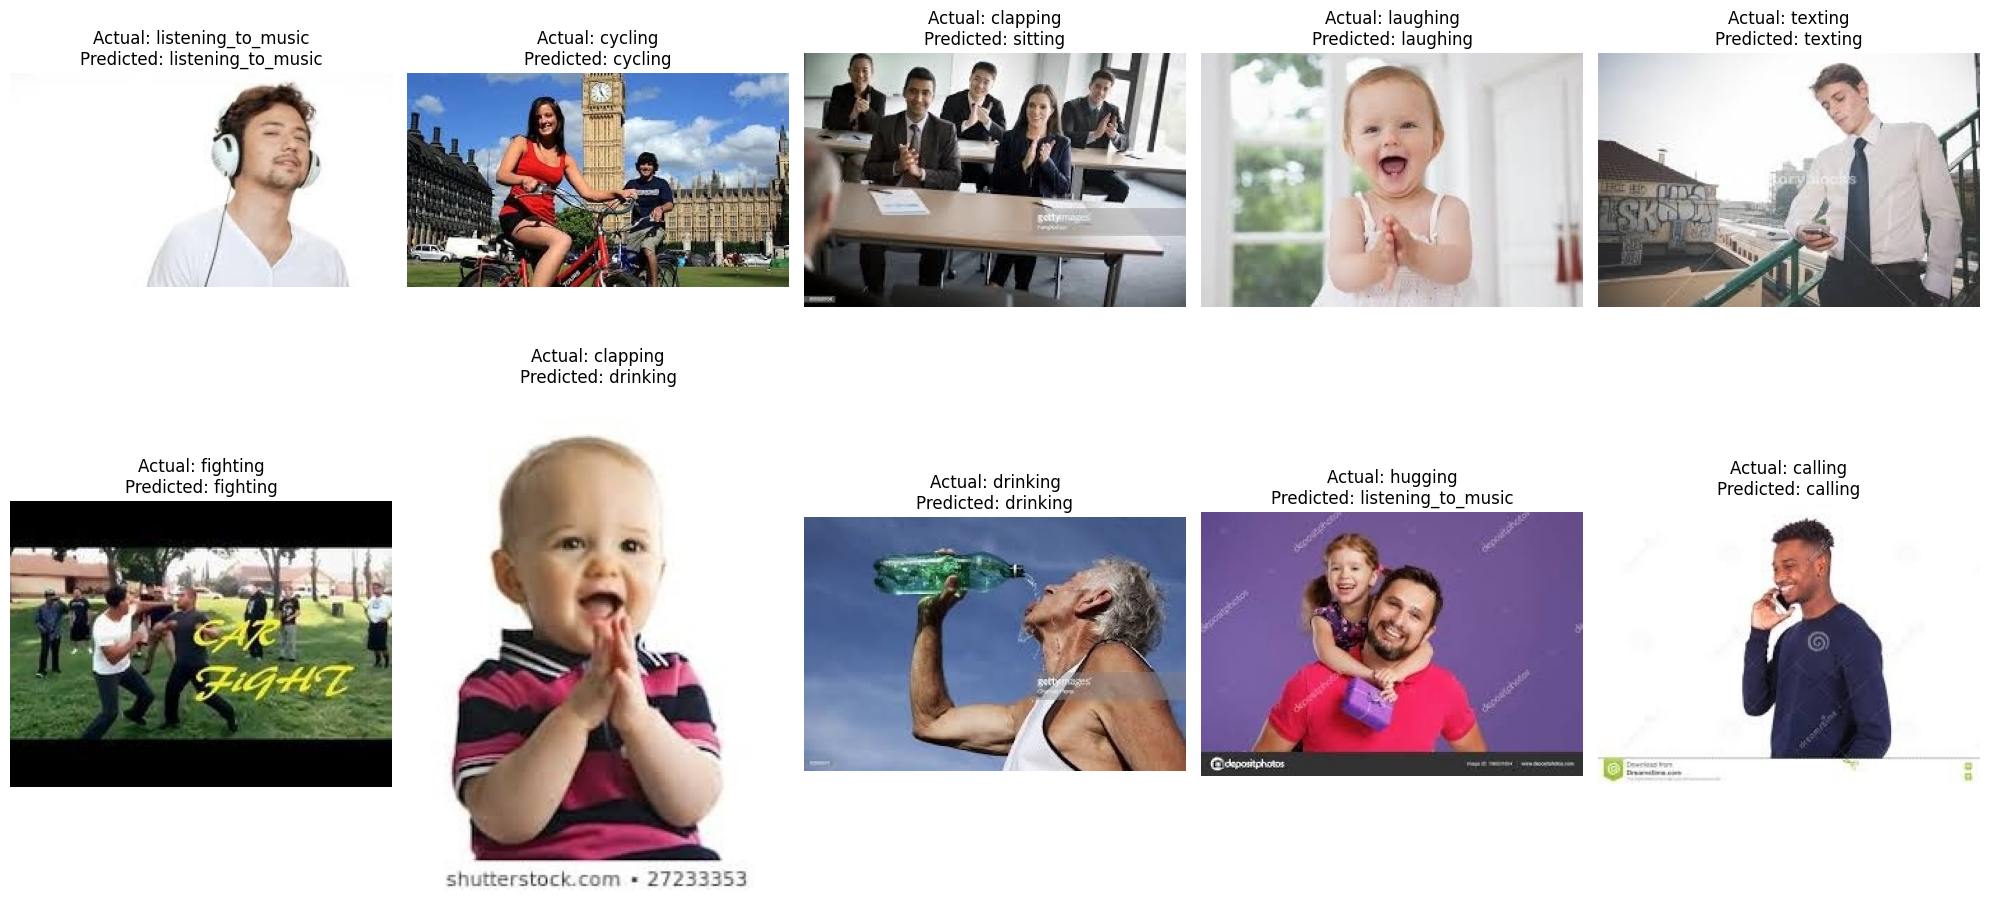

In [88]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()
sampled_val_set = val_set.sample(10, random_state=42)
for i, (index, row) in enumerate(sampled_val_set.iterrows()):
    img = plt.imread(row['filepath'])
    actual_label = categories[row['label']]
    predicted_label = categories[val_predictions[val_set.index.get_loc(index)]]
    axes[i].imshow(img)
    axes[i].set_title(f"Actual: {actual_label}\nPredicted: {predicted_label}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()
